# *Projection-Free Kernel Principal Component Analysis (PFKPCA)*
#### *A.T. Bui, J.-K. Im and D.W. Apley et al. / Neurocomputing 357 (2019) 163–176*

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')

import pfkpca as pf

def highlight_min(data, color='yellow'):
    '''
    highlight the minimum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_min = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

## *Generate random noisy $y = x^2$ data*
---

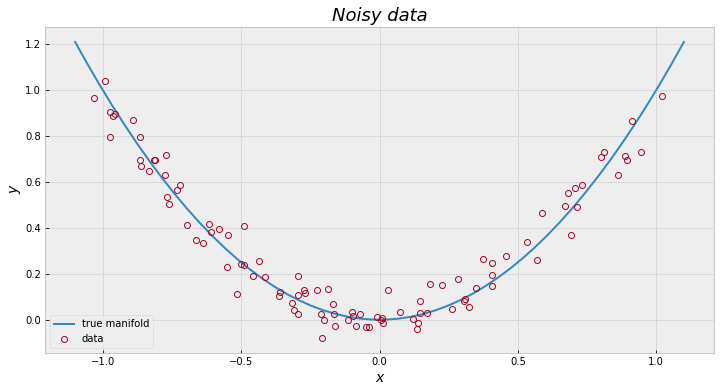

In [2]:
np.random.seed(15)  # fix the RNG state
N  = 100  # Number of points
t  = np.random.uniform(-1, 1, N)  # Numbers from U(-1,1)
x_true = np.array([t, t**2])
w1 = np.random.normal(0, 0.05, N) # Gaussian noise N(mu, sigma)
w2 = np.random.normal(0, 0.05, N) # Gaussian noise N(mu, sigma)
noisy_data  = x_true + np.array([w1, w2]) # Noisy dataset
M, N = noisy_data.shape

_, ax = plt.subplots(figsize=(12,6))
x_tm = np.linspace(-1.1,1.1)
ax.plot(x_tm, x_tm**2, ls='-', marker='', label='true manifold')
ax.plot(noisy_data[0,:], noisy_data[1,:], ls='', marker='o', markerfacecolor='none', label='data')
ax.set_title('Noisy data', fontsize=18, fontstyle='italic')
ax.set_xlabel('x', fontsize=14, fontstyle='italic')
ax.set_ylabel('y', fontsize=14, fontstyle='italic')
ax.legend()
pass; 

## *PFKPCA* | *Poly 2nd degree* 
---

### *Hyperparameter tuning: Find the dimension of the principal subspace, $L$ based on $r_1$ score* 

In [3]:
r1 = dict()
for L in [3,4,5]: # this range can be extended further but we limit it for simplicity
    denoised_data, _, _, _ = pf.pfkpca(noisy_data, L, kernel='poly', coeff=1.0, d=2, 
                                       h=1.2, I=500, show_proj=False, show_gradescent=False, show_denoised=False,
                                       contour_levels=40, verb=False)
    r1[L] = pf.r1(denoised_data, noisy_data, x_true)
r1

{3: 0.8733022152707756, 4: 0.6935777091577364, 5: 1.012438498689258}

### $L=4$ *gives the best denoising performance.* 
### *Run PFKPCA with the determined hyperparameter.* 

PFKPCA: Step 0 - Perform KPCA...


PFKPCA: Step 1 - Find the direction of the steepest descend: 100%|██████████| 100/100 [00:01<00:00, 57.00img/s]
PFKPCA: Step 2 & 3 - Denoise the data: 100%|██████████| 100/100 [00:02<00:00, 44.74img/s]




PFKPCA: Step 0 - Perform KPCA took 0.4930 seconds
PFKPCA: Step 1 - Direction of the steepest descend took 3.2025 seconds
PFKPCA: Step 2 & 3 - Denoise the data took 2.2395 seconds
PFKPCA took 5.9354 seconds


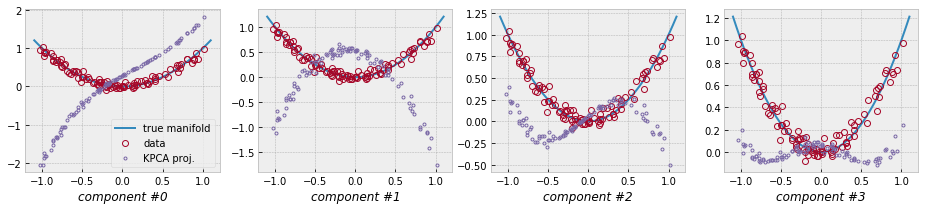

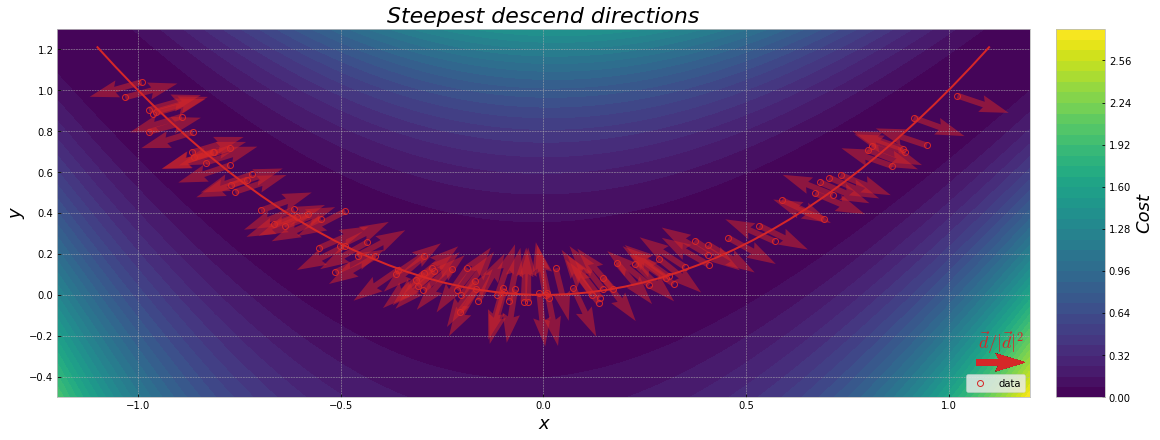

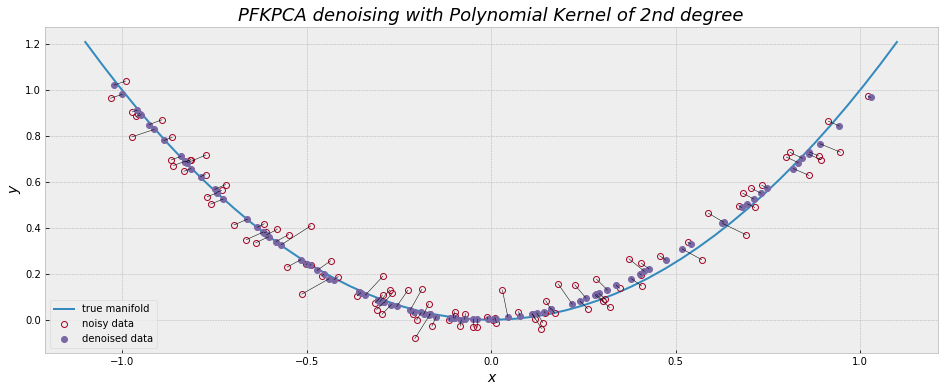

In [4]:
denoised_data, kpca_res, descend_dir, _ = pf.pfkpca(noisy_data, L=4, kernel='poly', coeff=1.0, d=2, 
                                                    h=1.2, I=500, show_proj=True, show_gradescent=True, show_denoised=True,
                                                    contour_levels=40, verb=True)

## *PFKPCA* | *RBF*
---

### *Hyperparameter tuning: Find the dimension of the principal subspace, $L$, and the value of the smoothing scale parameter, $\rho$, of the RBF kernel based on $r_1$ score* 

In [5]:
r1 = dict()
Ls = [6,7,8] # Ls and rho_ms ranges can be extended further but we limit it for simplicity
rho_ms = np.arange(1.0,2.5,.5)
for L in Ls:
    r1[L] = list()
    for rho_m in rho_ms:
        denoised_data, _, _, _ = pf.pfkpca(noisy_data, L, kernel='rbf', rho_m=rho_m, 
                                           show_proj=False, show_gradescent=False, show_denoised=False,
                                           contour_levels=40, verb=False)
        r1[L].append(pf.r1(denoised_data, noisy_data, x_true))
df = pd.DataFrame(data=r1, index=rho_ms)
df.style.apply(highlight_min, axis=None)

,6,7,8
1.0,0.869500,0.751812,0.793367
1.5,0.859945,0.706459,0.751169
2.0,0.843651,0.717654,0.748058


### *Best $r_1$ score is obtained for $L=7$ and $\rho = 1.5$. Now fine-tune the $\rho$*

In [6]:
r1 = list()
L = 7
rho_ms = np.linspace(1.5,1.6,10)
for rho_m in rho_ms:
    denoised_data, _, _, _ = pf.pfkpca(noisy_data, L, kernel='rbf', rho_m=rho_m, 
                                       show_proj=False, show_gradescent=False, show_denoised=False,
                                       contour_levels=40, verb=False)
    r1.append(pf.r1(denoised_data, noisy_data, x_true))
np.argmin(r1), rho_ms[np.argmin(r1)], r1[np.argmin(r1)]

(7, 1.577777777777778, 0.7012826951509352)

### *Best $r_1$ score is obtained for $L=7$ and $\rho = 1.58$.*
### *Run PFKPCA with the determined hyperparameters.*

PFKPCA: Step 0 - Perform KPCA...


PFKPCA: Step 1 - Find the direction of the steepest descend: 100%|██████████| 100/100 [00:00<00:00, 8356.19img/s]
PFKPCA: Step 2 & 3 - Denoise the data: 100%|██████████| 100/100 [00:00<00:00, 197.77img/s]




PFKPCA: Step 0 - Perform KPCA took 0.3609 seconds
PFKPCA: Step 1 - Direction of the steepest descend took 2.3133 seconds
PFKPCA: Step 2 & 3 - Denoise the data took 0.5126 seconds
PFKPCA took 3.1871 seconds


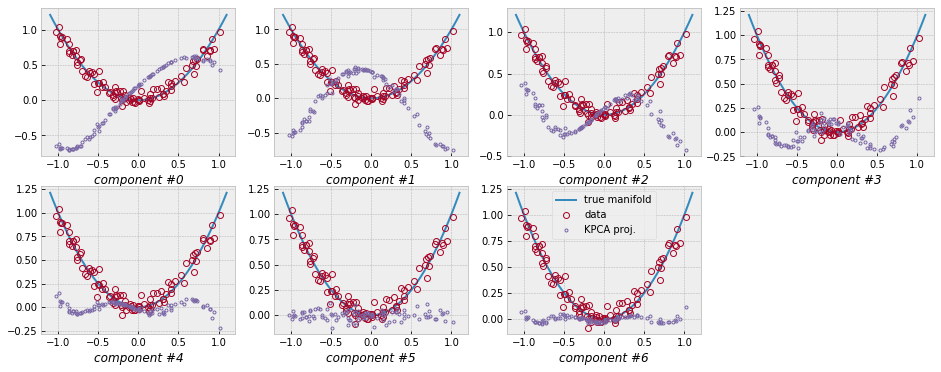

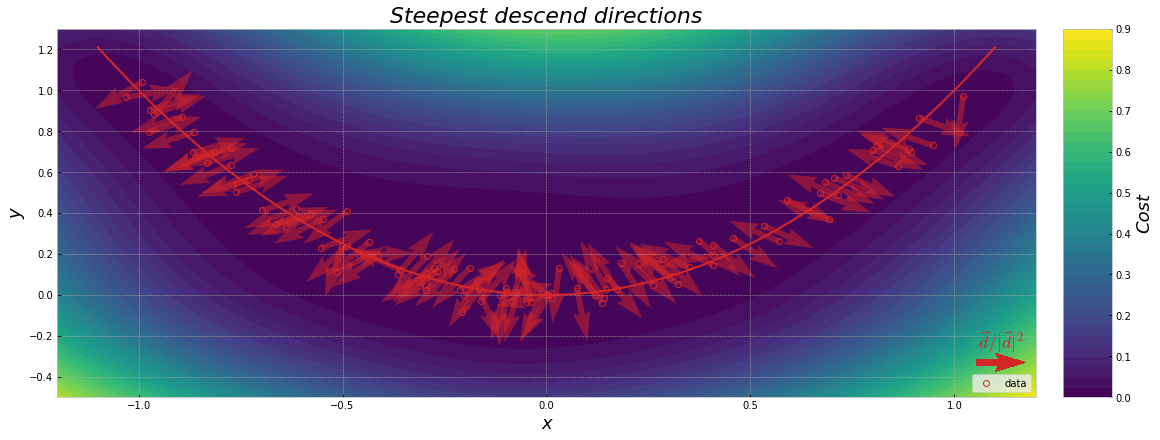

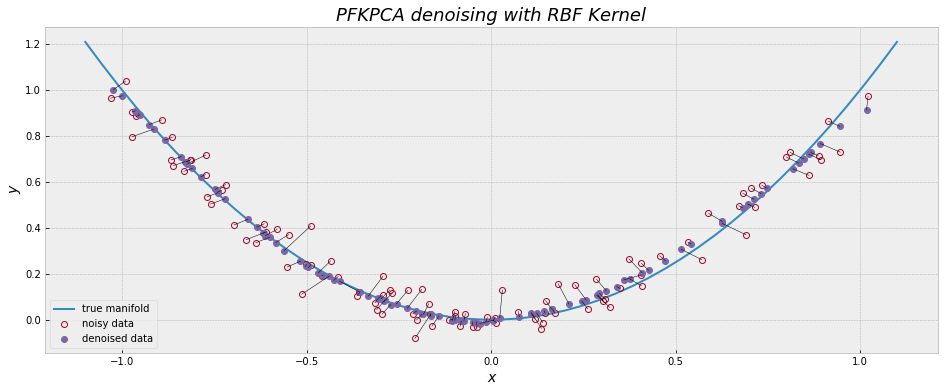

In [7]:
denoised_data, kpca_res, descend_dir, z_star = pf.pfkpca(noisy_data, L=7, kernel='rbf', rho_m=1.58, 
                                                         show_proj=True, show_gradescent=True, show_denoised=True,
                                                         contour_levels=40, verb=True)